In [71]:
import os
data_dir = 'C:/Users/kamar/OneDrive/Desktop'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [72]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [73]:
where_are_nan = np.isnan(float_data)
where_are_inf = np.isinf(float_data)
float_data[where_are_nan] = 1e-10
float_data[where_are_inf] = 1e-10

In [74]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)+0.000001
float_data /= std

In [75]:
where_are_nan = np.isnan(float_data)
where_are_inf = np.isinf(float_data)
float_data[where_are_nan] = 1e-10
float_data[where_are_inf] = 1e-10 

In [76]:
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):
    
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [77]:
lookback = 1440
step = 6
delay = 144
batch_size = 100

In [78]:
train_gen = generator(float_data,lookback=lookback,delay=delay,min_index=0,max_index=200000,shuffle=True,step=step,batch_size=batch_size)
val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=200001,max_index=300000,step=step,batch_size=batch_size)
test_gen = generator(float_data,lookback=lookback,delay=delay,min_index=300001,max_index=None,step=step,batch_size=batch_size)
val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)
val_steps = val_steps // batch_size
test_steps = test_steps // batch_size

In [79]:
train_gen

<generator object generator at 0x000002DE4C52AE60>

In [80]:
'''
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
'''

"\nimport matplotlib.pyplot as plt\nloss = history.history['loss']\nval_loss = history.history['val_loss']\nepochs = range(1, len(loss) + 1)\nplt.figure()\nplt.plot(epochs, loss, 'bo', label='Training loss')\nplt.plot(epochs, val_loss, 'b', label='Validation loss')\nplt.title('Training and validation loss')\nplt.legend()\nplt.show()\n"

In [81]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.LSTM(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 15,777
Trainable params: 15,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 36s 73ms/step - loss: 0.3509 - val_loss: 0.3047
Epoch 2/20
500

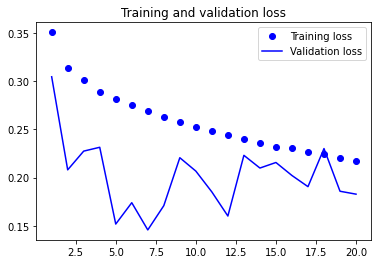

In [82]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()